# Fixes need to do:
## we need to fix the vanishing calcaulations in the nets, maybe amplifying all the values by some factor (100 maybe to get to normal values) and in the end we can just shrink the result (only the output) in the real test

## Add the normalization (around 0) of the the outputs - if the nets doesn't do it naturally

## Maybe initialize the weights to a big number because all the values are very small

## Add the scipy snippet to resample the vectors to be the same vector (DONE)

## MAYBE change the fully connected layers to go from each cell to an output instead of merging all the outputs to a big vector and forwarding it through a big FC

# Libraries Imports

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import os
import string 
# from google.colab import drive
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
import time
import matplotlib.pyplot as plt
import pandas as pd
import os
from data import *
from Nets import device
import Nets
import hyper_parameters as hp
from Data_Handling import *
import training
from training import calc_loss

checking for device (GPU)

In [2]:
# drive.mount('/content/drive')
print('training on: ',device)


training on:  cuda


In [3]:
# dataset = SpectraDataset()
train_loader, test_loader, val_loader, std_dict = getLoader(seed=1)

In [4]:
print(std_dict)

{'min source': 4992.544013409346, 'max source': 5087.104146943163, 'min target': 4990.122000000003, 'max target': 5079.972000001964, 'source len': 7500, 'target len': 1700, 'vector source': array([4992.54401341, 4992.55662311, 4992.56923281, ..., 5087.07892754,
       5087.09153724, 5087.10414694]), 'vector target': array([4990.122     , 4990.17488405, 4990.2277681 , ..., 5079.8662319 ,
       5079.91911595, 5079.972     ])}


In [11]:
doppler1 = Nets.load_model_from_mode('doppler', True, 0.5, 0.0001, name='together').to(device)
doppler2 = Nets.load_model_from_mode('doppler', True, 0.5, 0.00011).to(device) #trained sperated

In [54]:
spectra_net = Nets.load_model_from_mode('spectra', True, 0.7, 5e-6).to(device)
spectra_net2 = Nets.load_model_from_mode('spectra', True, 0.6, 1e-5).to(device)


In [7]:
training.check_spectra_model(spectra_net, train_loader)
training.check_spectra_model(spectra_net, val_loader)
training.check_spectra_model(spectra_net, test_loader)

Loss: 0.2452...
Loss: 0.2459...
Loss: 0.2504...


0.2504271636051791

In [20]:
training.check_spectra_model(spectra_net, train_loader)

Loss: 0.2452...


0.24518773713532616

# The Training - SpectraNet
### 1. sum the losses
of each spectra and then backprop - I think it will backprop in the net twice (for each spectra)
### 2. train 
the first layers until spectra1 and then only the last FC on the spectra2 with all the others params grad's are off

In [39]:
spectr = Nets.SpectraNet(drop=0.7).to(device)


In [40]:
epochs_amount = 15
opt = optim.Adam(spectr.parameters(), weight_decay = 1e-1, lr=5e-5) # lr with best result on adam
lambda_lr = lambda epoch: 0.5 if epoch+1 >= (epochs_amount//5)+1 and (epoch+1)%2 == 0 else 1
sched = optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda = lambda_lr)
spectr, train_loss, val_loss = training.train_spectra1(spectr, opt, sched, train_loader, val_loader, epochs=epochs_amount)
training.check_spectra_model(spectr, train_loader)
training.check_spectra_model(spectr, val_loader)
training.check_spectra_model(spectr, test_loader)

Epoch: 1/15... Train Loss: 1.5609... Validation Loss: 1.3937... LR: [5e-05]
Epoch: 2/15... Train Loss: 0.5526... Validation Loss: 0.2874... LR: [5e-05]
Epoch: 3/15... Train Loss: 0.2688... Validation Loss: 0.2623... LR: [5e-05]
Epoch: 4/15... Train Loss: 0.2541... Validation Loss: 0.2530... LR: [2.5e-05]
Epoch: 5/15... Train Loss: 0.2521... Validation Loss: 0.2558... LR: [2.5e-05]
Epoch: 6/15... Train Loss: 0.2490... Validation Loss: 0.2440... LR: [1.25e-05]
Epoch: 7/15... Train Loss: 0.2509... Validation Loss: 0.2433... LR: [1.25e-05]
Epoch: 8/15... Train Loss: 0.2467... Validation Loss: 0.2425... LR: [6.25e-06]
Epoch: 9/15... Train Loss: 0.2469... Validation Loss: 0.2420... LR: [6.25e-06]
Epoch: 10/15... Train Loss: 0.2414... Validation Loss: 0.2422... LR: [3.125e-06]
Epoch: 11/15... Train Loss: 0.2428... Validation Loss: 0.2402... LR: [3.125e-06]
Epoch: 12/15... Train Loss: 0.2417... Validation Loss: 0.2408... LR: [1.5625e-06]
Epoch: 13/15... Train Loss: 0.2415... Validation Loss: 0

0.24114310209240233

Loss: 0.2373...


0.23730858047218883

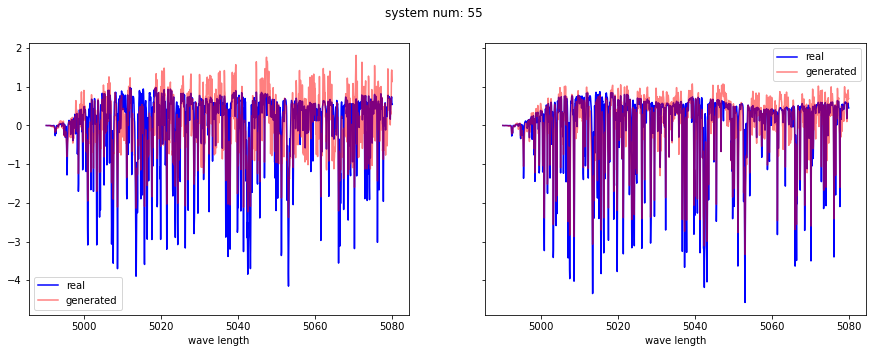

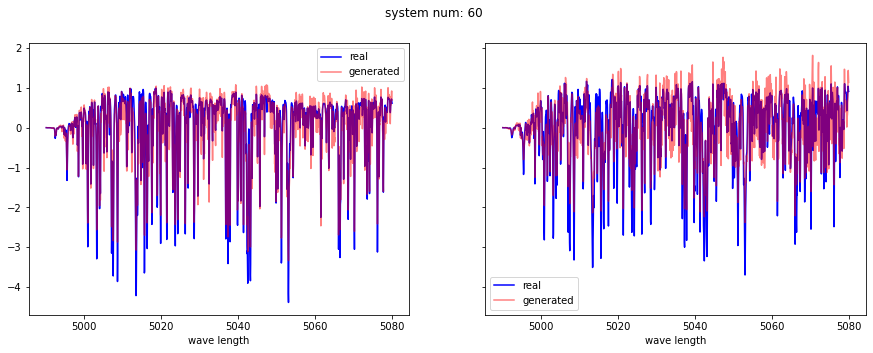

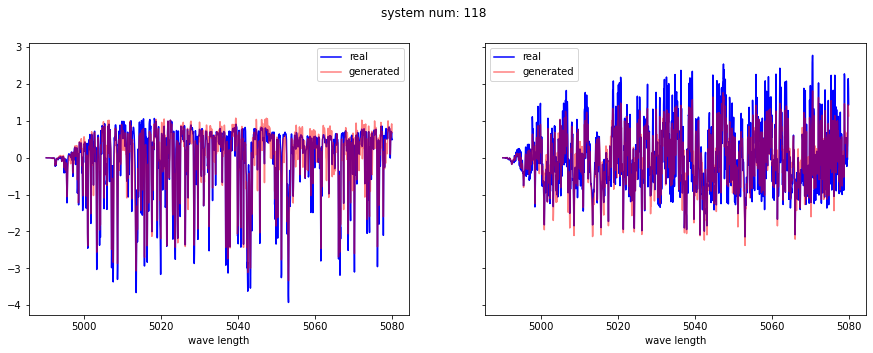

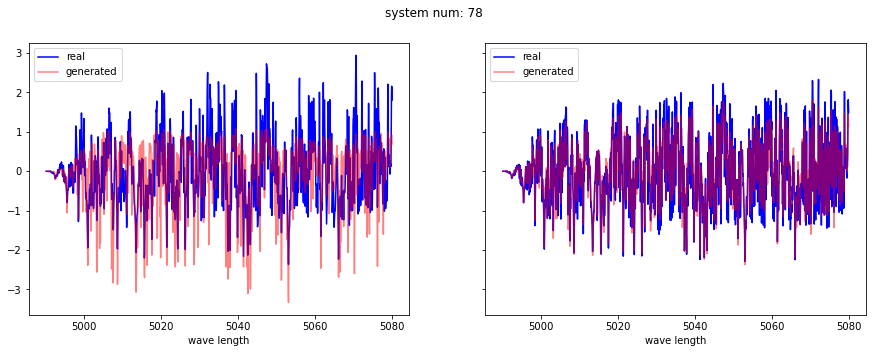

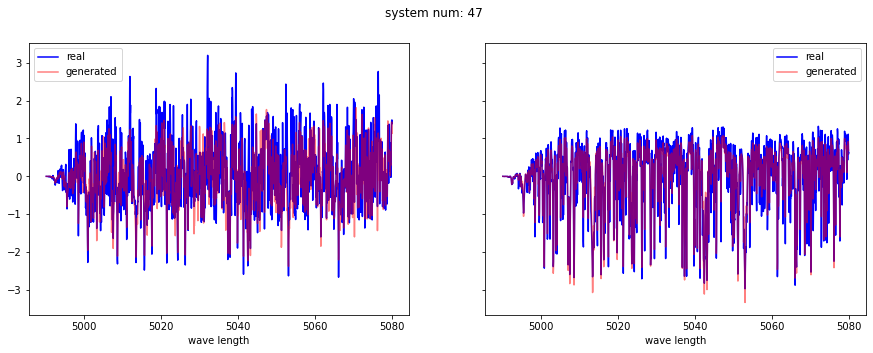

In [41]:
training.check_spectra_model(spectr, train_loader, 5, std_dict['vector target'])

# Train - DopplerNet

In [48]:
doppler_rep = Nets.DopplerNet(drop=0.5).to(device)

In [49]:
epochs_amount = 15
opt = optim.Adam(doppler_rep.parameters(), weight_decay = 1e-2,lr=0.0001) # lr with best result on adam
lambda_lr = lambda epoch: 0.5 if epoch+1 >= (epochs_amount//3)*2 and (epoch+1)%2 == 0 else 1
sched = optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda = lambda_lr)
doppler_rep, train_loss, val_loss = training.train_doppler_together25(spectra_net, doppler_rep, opt, sched, train_loader, val_loader, epochs=epochs_amount)


Epoch: 1/15... Train Loss: 114.8384... Validation Loss: 120.0756... LR: [0.0001]
Epoch: 2/15... Train Loss: 69.8059... Validation Loss: 46.3102... LR: [0.0001]
Epoch: 3/15... Train Loss: 40.5220... Validation Loss: 36.5425... LR: [0.0001]
Epoch: 4/15... Train Loss: 34.5149... Validation Loss: 41.3843... LR: [0.0001]
Epoch: 5/15... Train Loss: 31.1704... Validation Loss: 39.4508... LR: [0.0001]
Epoch: 6/15... Train Loss: 29.4868... Validation Loss: 38.4236... LR: [0.0001]
Epoch: 7/15... Train Loss: 27.8374... Validation Loss: 32.6860... LR: [0.0001]
Epoch: 8/15... Train Loss: 25.4373... Validation Loss: 34.6871... LR: [5e-05]
Epoch: 9/15... Train Loss: 24.4230... Validation Loss: 33.7369... LR: [5e-05]
Epoch: 10/15... Train Loss: 24.0507... Validation Loss: 31.3484... LR: [2.5e-05]
Epoch: 11/15... Train Loss: 22.4825... Validation Loss: 30.5716... LR: [2.5e-05]
Epoch: 12/15... Train Loss: 22.8366... Validation Loss: 29.9968... LR: [1.25e-05]
Epoch: 13/15... Train Loss: 22.5776... Valida

## Testing the spectra and doppler together

Spectra Loss: 0.2504... Doppler Loss: 23.1128...


(0.2504271636051791, 23.11284055028643)

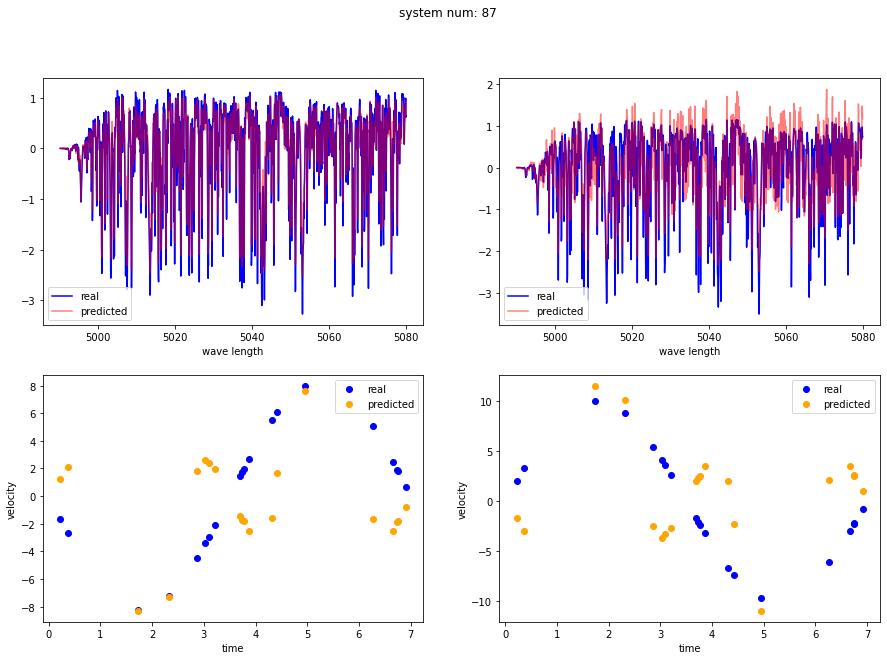

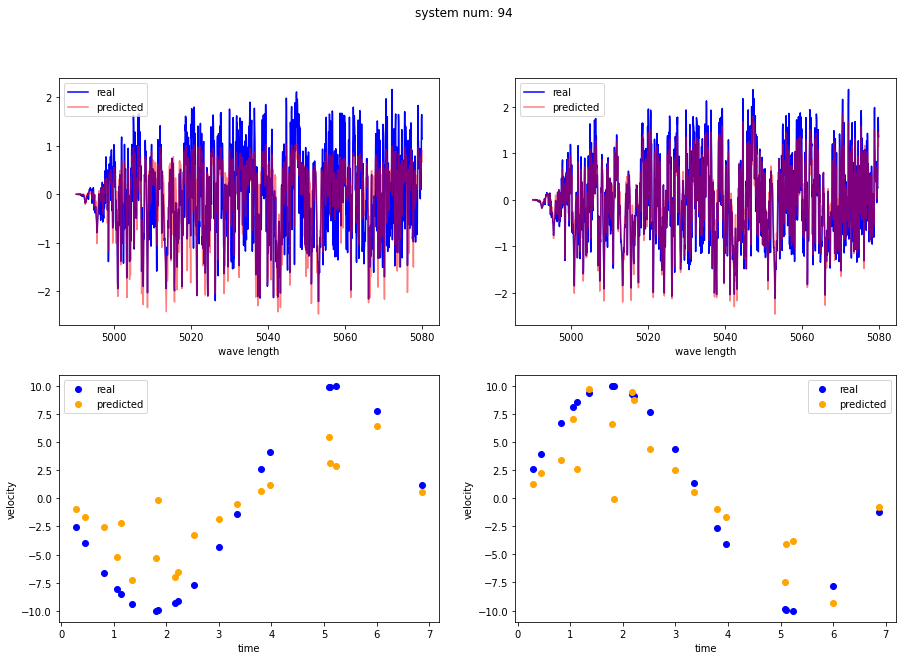

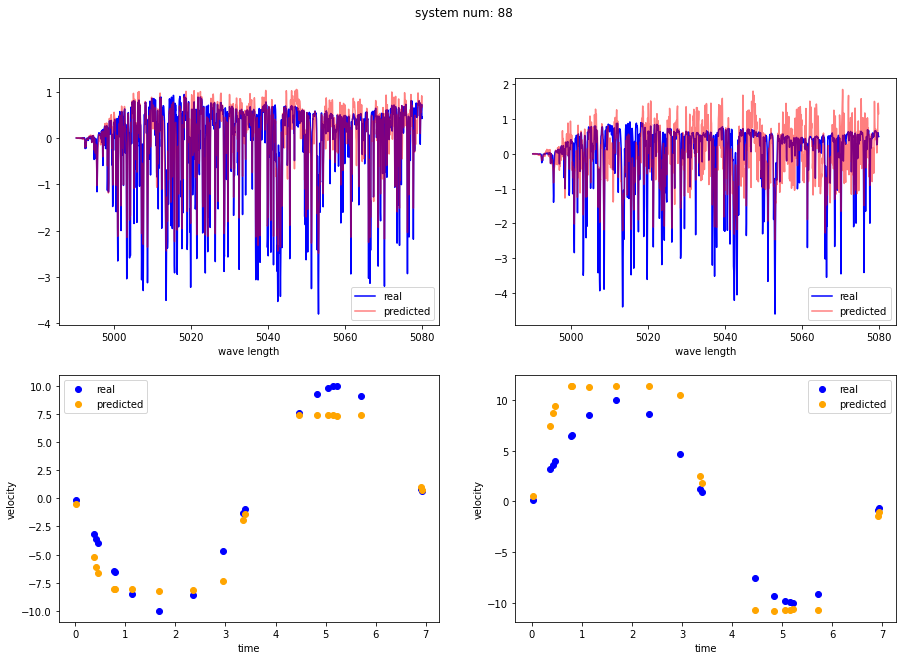

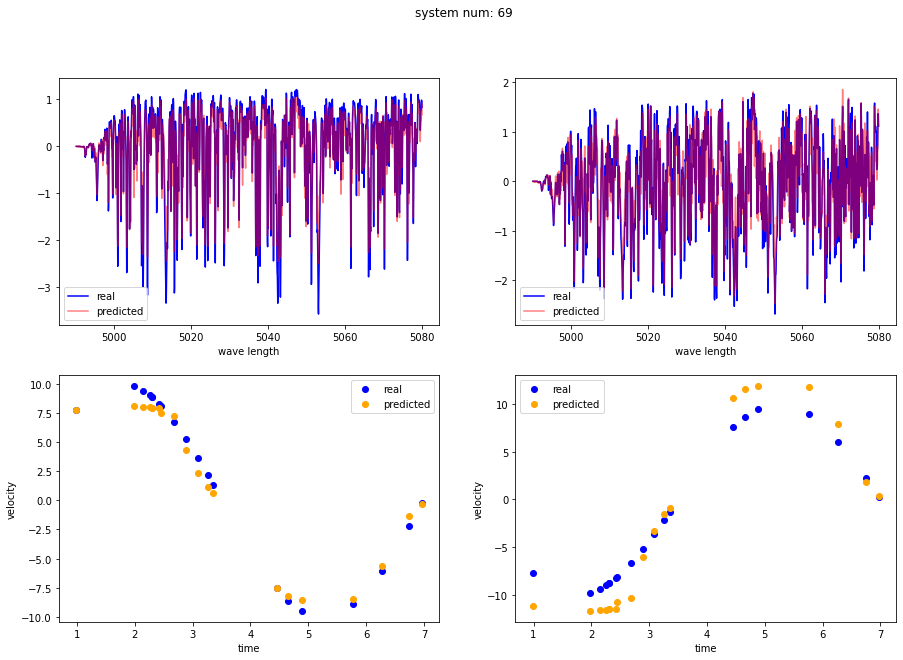

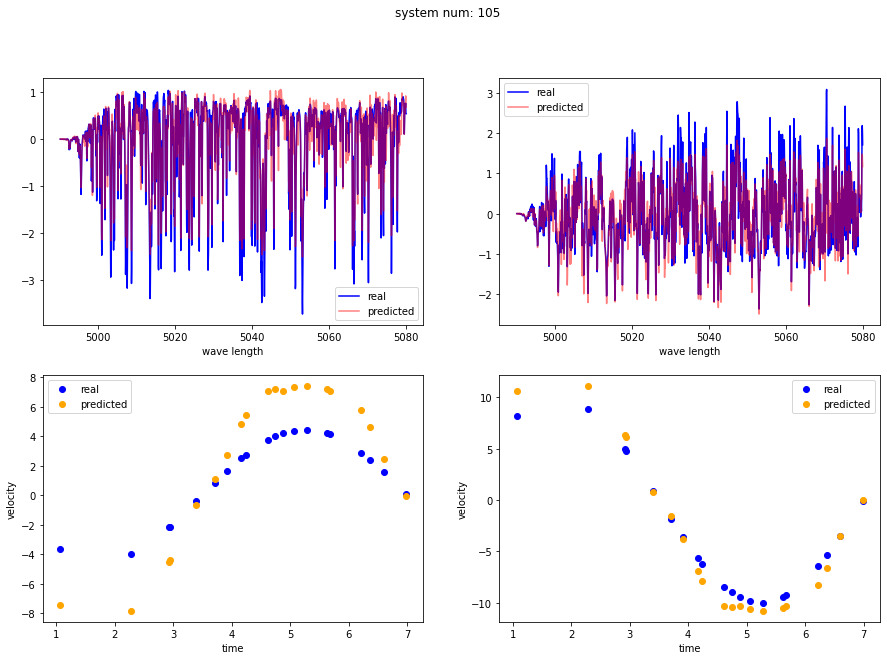

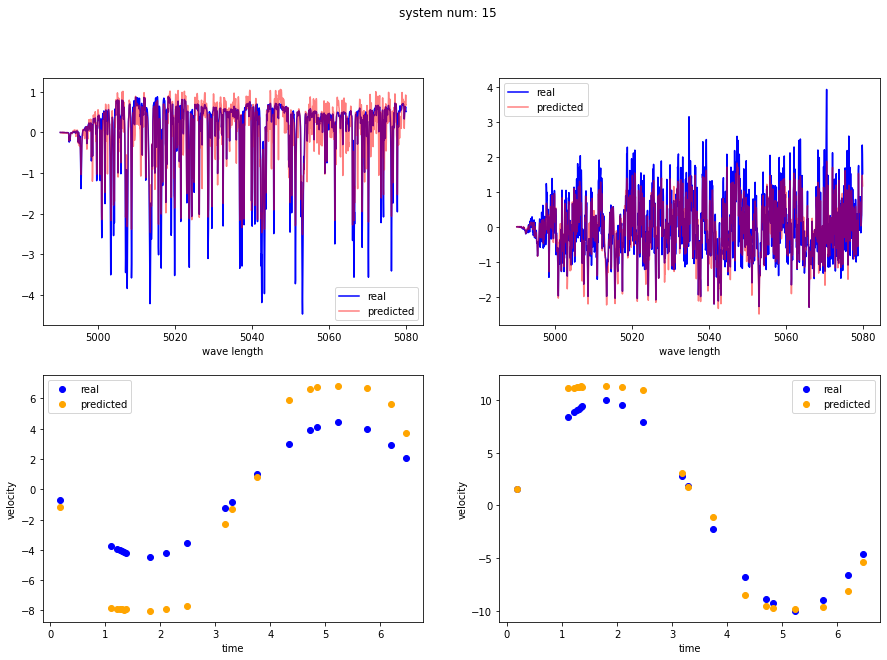

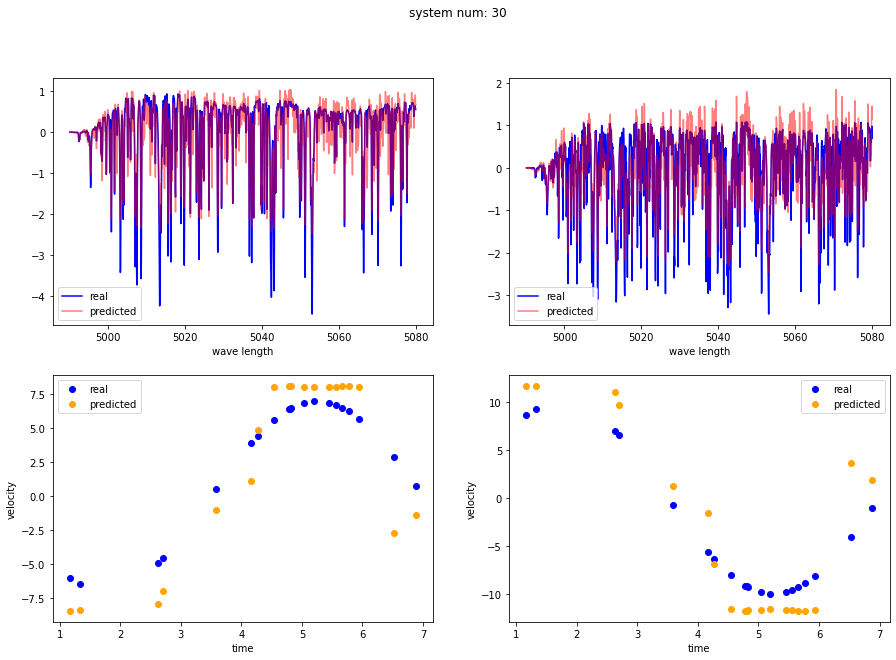

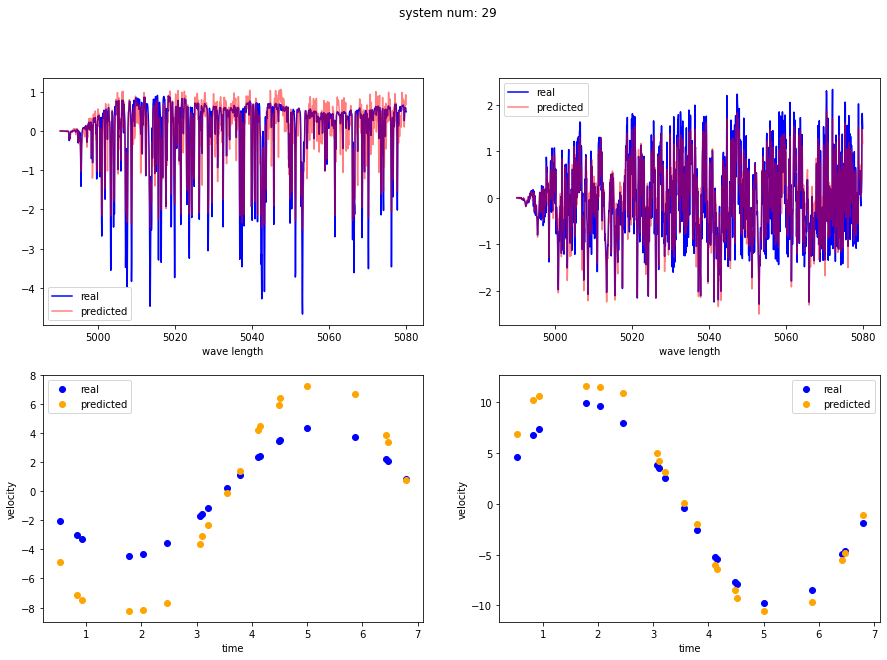

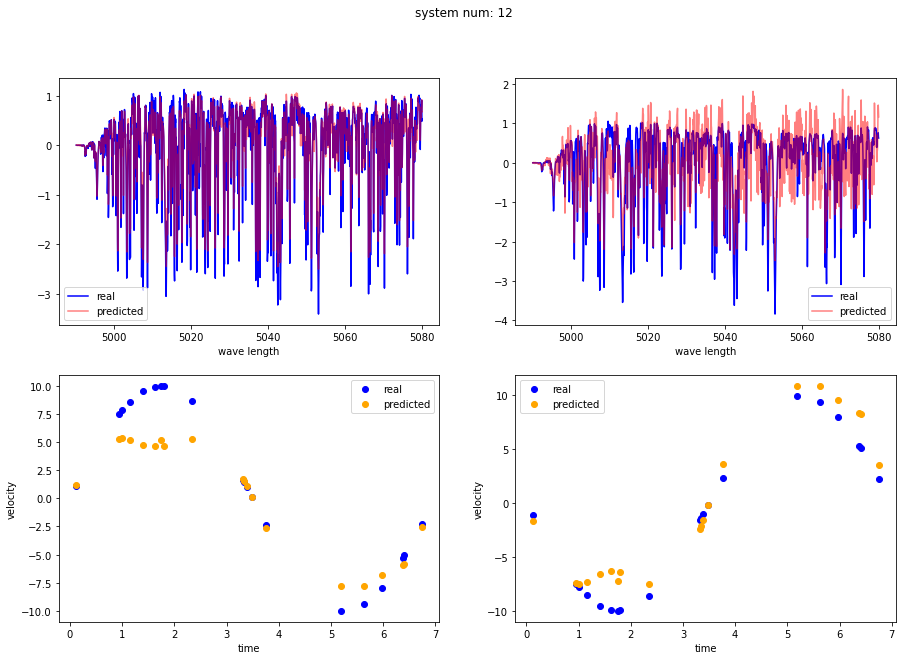

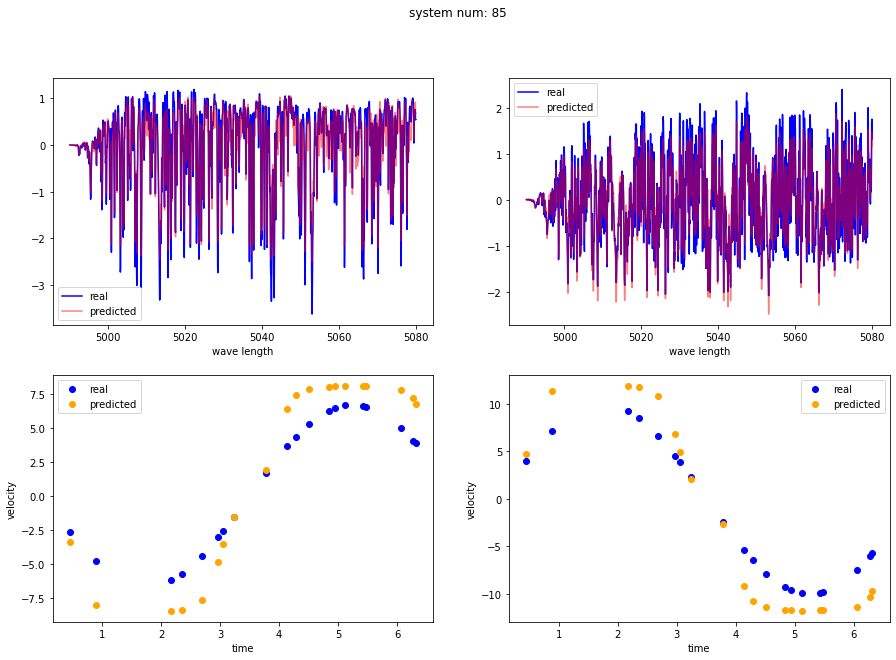

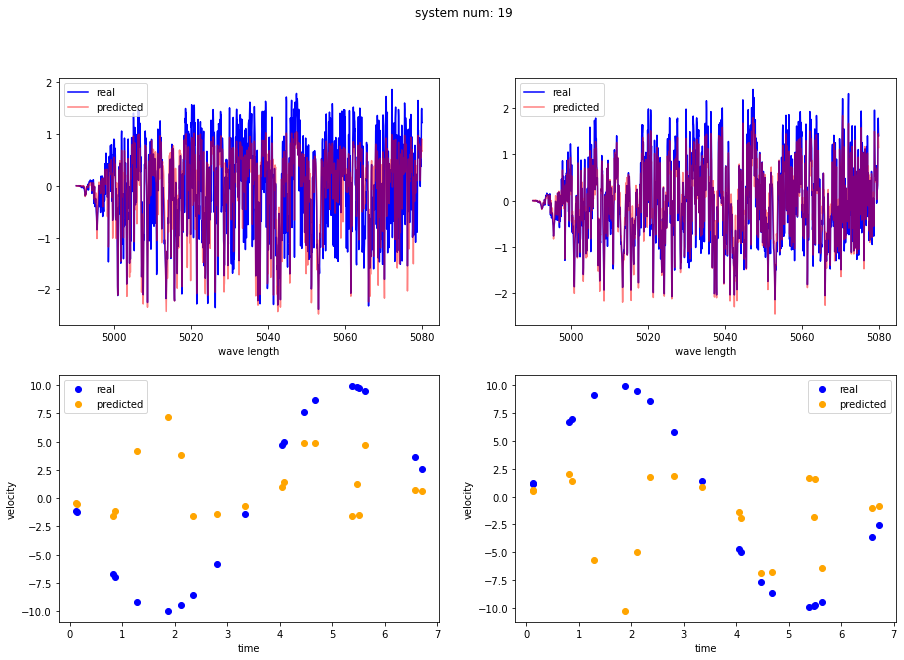

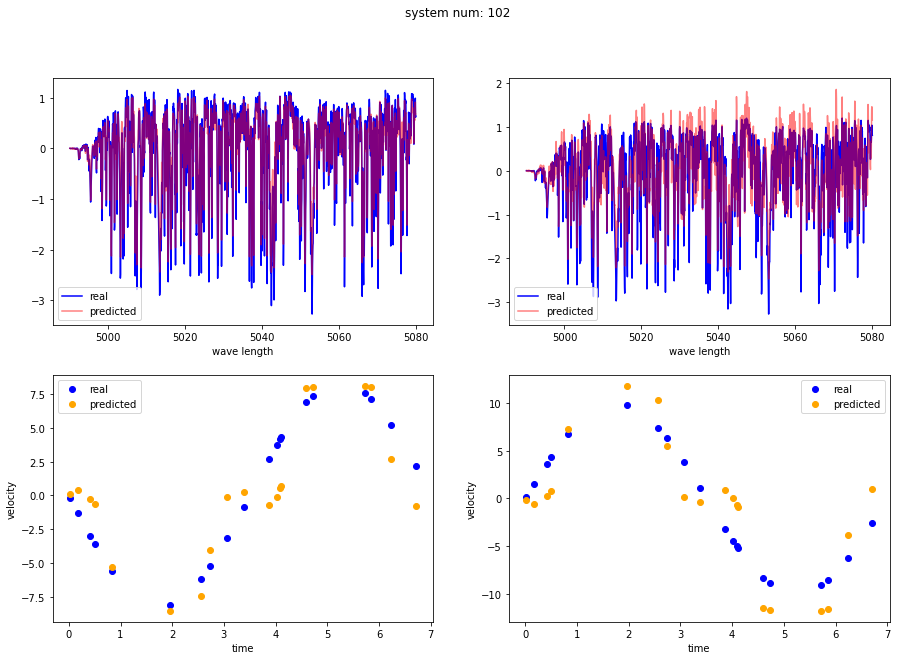

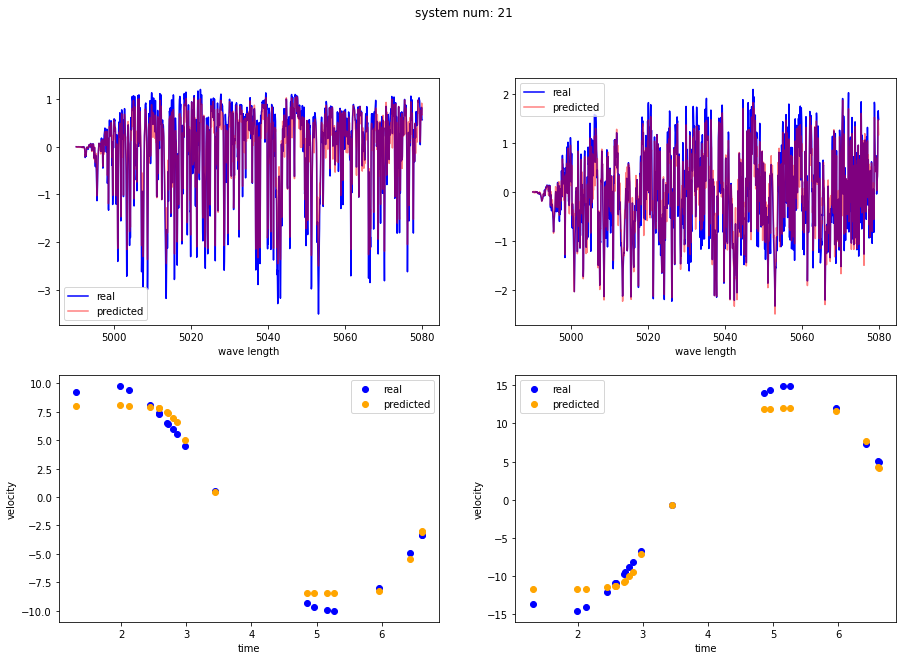

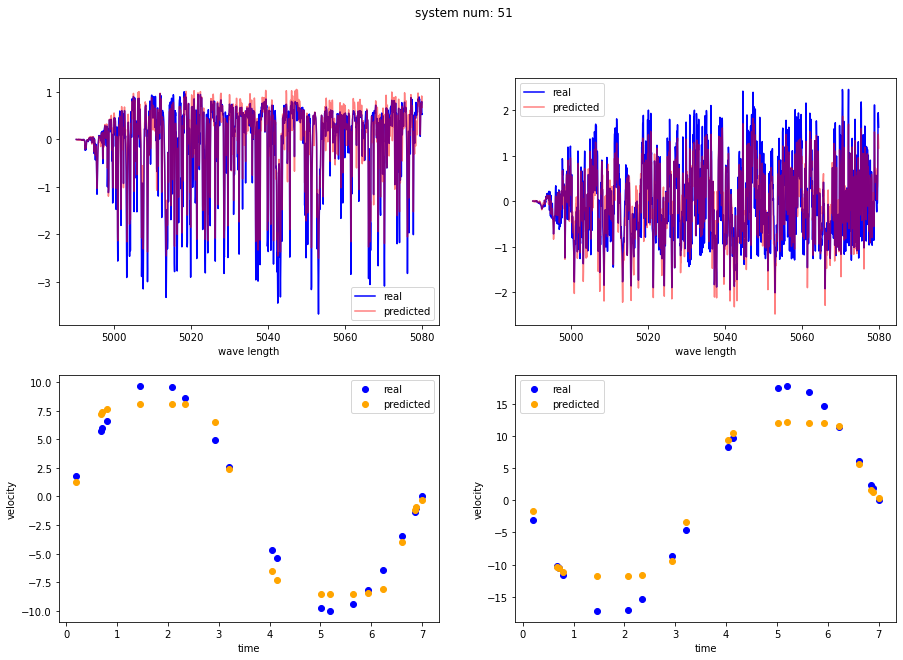

In [12]:
training.check_all_forward(spectra_net, doppler1, test_loader, 15, std_dict['vector target'])

In [ ]:
del spectra_net
torch.cuda.empty_cache()

## Train new Model

In [ ]:
plt.figure()
plt.plot(range(epochs_amount), train_loss, label = 'train')
plt.plot(range(epochs_amount), val_loss, label = 'validation')
plt.legend()

In [ ]:
training.check_spectra_model(spectra_net, val_loader, 10, std_dict['vector target'])

## Test all forward


In [ ]:
print(std_dict)

In [ ]:
plt.figure()
plt.plot(tr, label = 'training')
plt.plot(vl, label = 'validation')
plt.legend()

## Test the real star velocity, it's an eccentric star (not like the ones in our data - very different) and we are still getting pretty good results

In [18]:
real = get_real_loader(std_dict)


### parametrs for plotting the results

In [22]:
repeat_time = 158.38
new_times = torch.tensor([0.5258358498103917, 311.78148982999846, 341.84771745977923, 433.56606571003795, 1087.7946868599392, 1087.6849441300146, 1088.5976183298044, 1088.6789588402025, 1128.6752032698132, 1128.5791229400784, 1129.6505303801969, 1129.5734185199253, 1130.54320129985, 1135.6618717098609, 1136.5898129399866, 1136.6504905801266, 1137.620776989963, 1137.5821229401045, 1548.5132086100057,1561.4949623998255])
velocities = torch.tensor([[ 0.4807,  3.4946,  3.4890,  2.6325,  3.3601,  2.6683,  2.7920,  4.4577,
          2.4410,  2.8286, -0.1037,  1.2503,  3.8465, -2.4791,  1.5586,  0.8806,
          4.8355,  3.2758,  5.2041, -0.3927], [-0.3747, -3.0976, -2.6736, -1.5612, -3.4014, -2.3724, -2.1985, -3.9267,
         -2.5787, -2.4000,  0.5146, -1.0211, -2.3276,  2.2298, -1.1851, -0.7104,
         -3.8605, -2.5371, -4.2727,  0.4841]]).to(device)

In [17]:
def test_real_star_spectra(spectra_net: Nets.SpectraNet, real: dict):
    standard_vector = std_dict['vector target']
    with torch.no_grad():
        loss_function = nn.MSELoss(reduction = 'mean')
        spectra_net.eval()
        seq_size, seq_amount, wave_amount = spectra_net.seq_size, spectra_net.seq_amount, spectra_net.wave_amount 

        with torch.no_grad():
            obs, specs, c = real[0], real[1], 'real'
            hidden = spectra_net.init_hidden() 
            obs, specs = split_vector_to_seqs(obs, seq_size, seq_amount, wave_amount).to(device), specs.to(device)
            spectra1, spectra2, hidden = spectra_net(obs, hidden, method=3)
            loss, _ = calc_loss(loss_function, spectra1, spectra2, specs[0,:].view(1, -1),specs[1,:].view(1, -1))

            display_graphs(loss_function, spectra1.view(-1), spectra2.view(-1), specs[0,:], specs[1,:], standard_vector, c)
        print("Loss: {:.4f}...".format(loss.item()))

Loss: 0.3820...


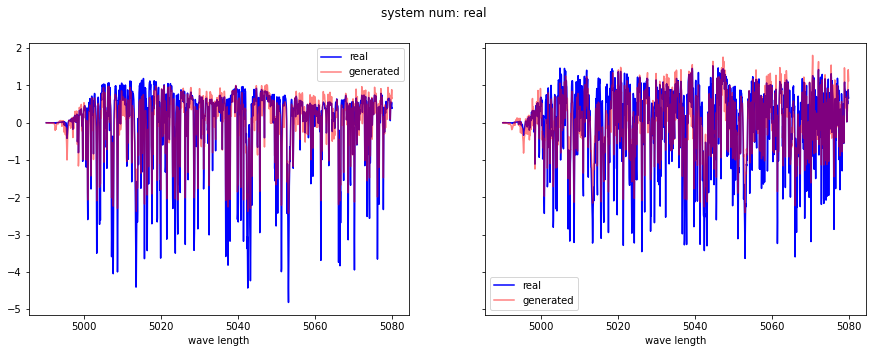

In [19]:
test_real_star_spectra(spectra_net, real)

### When we use the seperate doppler net

In [32]:
# ttt = [0.5258358498103917,311.78148982999846,341.84771745977923,433.56606571003795,1087.7946868599392,1087.6849441300146,1088.5976183298044,1088.6789588402025,1128.6752032698132,1128.5791229400784,1129.6505303801969,1129.5734185199253,1130.54320129985,1135.6618717098609,1136.5898129399866,1136.6504905801266,1137.620776989963,1137.5821229401045,1548.5132086100057,1561.4949623998255,1563.4780927198008]
def test_real_star_doppler_seperate(doppler_net: Nets.DopplerNet, real: dict, new_times, repeat_time, velocities):
    with torch.no_grad():
        loss_function = nn.MSELoss(reduction = 'mean')
        doppler_hidden = doppler_net.init_hidden()

        doppler_input = (torch.cat((real[0].repeat(2,1),
                                   torch.cat(
                                       (real[1][0,:].repeat(20,1), real[1][1,:].repeat(20,1)),0)),1)).type(torch.FloatTensor)

        doppler_input = split_vector_to_seqs(doppler_input, doppler_net.seq_size, doppler_net.seq_amount,
                                             doppler_net.combine_wave_input).to(device)
        output, doppler_hidden = doppler_net(doppler_input, doppler_hidden)
        #output = output.view(2,20)
        output = torch.transpose(output, 0,1)
    #     velocities = velocities.to(device)
        loss, direction = calc_loss(loss_function, output[0,:], output[1,:], velocities[0,:], velocities[1,:])
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (15, 5))
        ax1.scatter(new_times%repeat_time, velocities[direction,:].cpu().numpy(), label='real', color='blue')
        ax2.scatter(new_times%repeat_time, velocities[1-direction,:].cpu().numpy(), label='real', color='blue')
        ax1.scatter(new_times%repeat_time, output[0,:].cpu().numpy(), label='predicted', color='orange')
        ax2.scatter(new_times%repeat_time, output[1,:].cpu().numpy(), label='predicted', color='orange')
        f.suptitle(f'system num: {"real"}')
        ax1.set_xlabel('time')
        ax2.set_xlabel('time')
        ax1.set_ylabel('velocity')
        ax2.set_ylabel('velocity')
        ax1.legend()
        ax2.legend()
        print("Doppler Loss: {:.4f}...".format(loss.item()))


Doppler Loss: 3.2696...


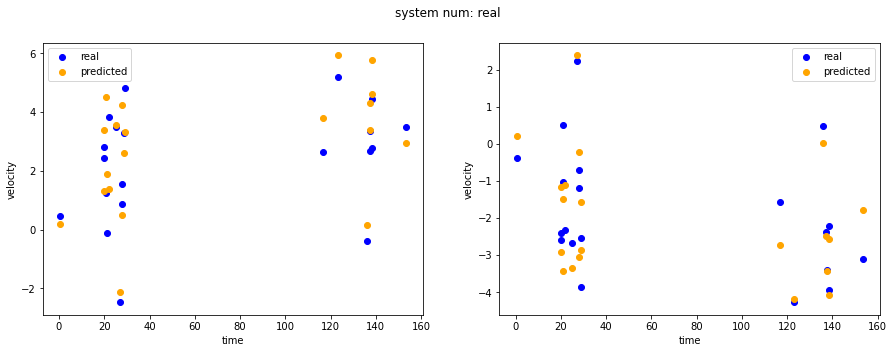

In [33]:
test_real_star_doppler_seperate(doppler2, real, new_times, repeat_time, velocities)

### When we use the together doppler net (with the spectra net)

In [38]:
def test_real_star_together(spectra_net: Nets.SpectraNet, doppler_net: Nets.DopplerNet, real: dict, new_times, repeat_time,
                            velocities, std_dict: dict):
    std_vec = std_dict['vector target']
    spectra_net.eval()
    doppler1.eval()
    loss_function = nn.MSELoss(reduction = 'mean')
    spec_seq_size, spec_seq_amount, spec_wave_amount = spectra_net.seq_size, spectra_net.seq_amount, spectra_net.wave_amount
    dop_seq_size, dop_seq_amount, dop_input_length = doppler_net.seq_size, doppler_net.seq_amount, doppler_net.combine_wave_input 

    with torch.no_grad():
        observ, specs, c = real[0], real[1], 'real'
        spec_hidden = spectra_net.init_hidden()
        dop_hidden = doppler_net.init_hidden()
        obs, specs = split_vector_to_seqs(observ, spec_seq_size, spec_seq_amount, spec_wave_amount).to(device), specs.to(device)
        spec_out = spectra_net(obs, spec_hidden, method=3)
        spec_hidden = spec_out[2]
        spec_loss, direction = calc_loss(loss_function, spec_out[0], spec_out[1], specs[0,:].view(1, -1), specs[1,:].view(1, -1))
        print('direction is:', direction)

    #     doppler_input = torch.cat((observ.to(device).repeat(2,1),
    #                           torch.cat((specs[direction,:].repeat(20,1), specs[1-direction,:].repeat(20,1)), 0)), 1).type(torch.FloatTensor)
        doppler_input = torch.cat((observ.to(device).repeat(2,1),
                              torch.cat((spec_out[direction][0].repeat(20,1), spec_out[1-direction][0].repeat(20,1)), 0)), 1)

    #             print(f'spectra1 size: {spectra1.size()}, specs: {specs[:, 0].size()}')
        output, doppler_val_hidden = doppler_net(split_vector_to_seqs(doppler_input, dop_seq_size, dop_seq_amount,
                                                                  dop_input_length).to(device), dop_hidden)
        output = torch.transpose(output,0,1)
        vel = velocities.to(device)
    #             '''HERE WE DO NEED THAT THE 1st VELOCITY WOULD CORRESPOND TO THE 1st OUTPUT AND VISE VERSA'''
        loss = loss_function(output[0,:], velocities[direction,:]) + loss_function(output[1,:], velocities[1-direction,:])
    #             loss = calc_loss(loss_function, output[0,:], output[1,:], vel[0,:], vel[1,:])
    #             loss = loss_function(output, velocities.to(device))
        dop_loss = loss.item()

        f, ax = plt.subplots(2, 2, sharey=False, figsize = (15, 10)) 
        # gen_a -> real_a, gen_b -> real_b
        ax[0,0].plot(std_vec, specs[direction,:].cpu().numpy(), color='blue', label = 'real')
        ax[0,1].plot(std_vec, specs[1-direction,:].cpu().numpy(), color='blue', label = 'real')
        ax[0,0].plot(std_vec, spec_out[0][0].cpu().numpy(), color='red', alpha = 0.5, label = 'predicted')
        ax[0,1].plot(std_vec, spec_out[1][0].cpu().numpy(), color='red', alpha = 0.5, label = 'predicted')
        ax[1,0].scatter(new_times%repeat_time, vel[direction,:].cpu().numpy(), color='blue', label='real')
        ax[1,1].scatter(new_times%repeat_time, vel[1-direction,:].cpu().numpy(), color='blue', label='real')
        ax[1,0].scatter(new_times%repeat_time, output[0,:].cpu().numpy(), color='orange', label='predicted')
        ax[1,1].scatter(new_times%repeat_time, output[1,:].cpu().numpy(), color='orange', label='predicted')
        ax[1,0].set_xlabel('time')
        ax[1,1].set_xlabel('time')
        ax[1,0].set_ylabel('velocity')
        ax[1,1].set_ylabel('velocity')
        ax[1,0].legend()
        ax[1,1].legend()
        f.suptitle(f'system num: {c}')
        ax[0,0].set_xlabel('wave length')
        ax[0,1].set_xlabel('wave length')
        ax[0,0].legend()
        ax[0,1].legend()
    print("Spectra Loss: {:.4f}...".format(spec_loss),
         "Doppler Loss: {:.4f}...".format(dop_loss))

direction is: 1
Spectra Loss: 0.3200... Doppler Loss: 20.9960...


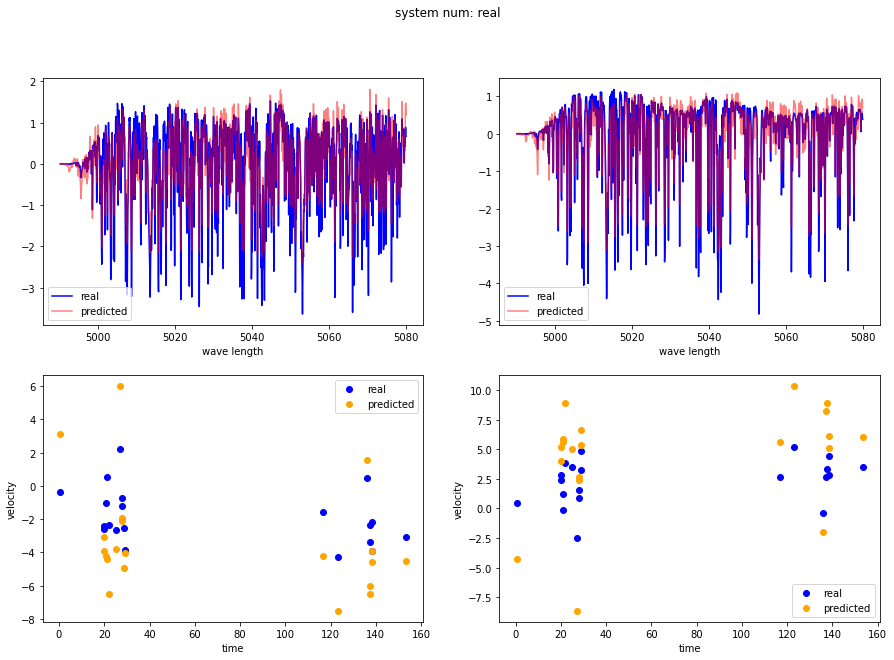

In [56]:
test_real_star_together(spectra_net2, doppler1, real, new_times, repeat_time, velocities, std_dict)

In [45]:
print(doppler_rep.parameters())

<generator object Module.parameters at 0x7faaedc8f050>
